## Support vector machine classifier with ℓ2-regularization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = pd.read_csv("https://raw.githubusercontent.com/pbharrin/machinelearninginaction/master/Ch06/testSet.txt", delimiter='\t', names=['x', 'y', 'label'])
data.head()

X = data[['x', 'y']].values
Y = data[['label']].values

### label 이 -1, +1 인 100개의 dataset을 2차원 평면에 시각화

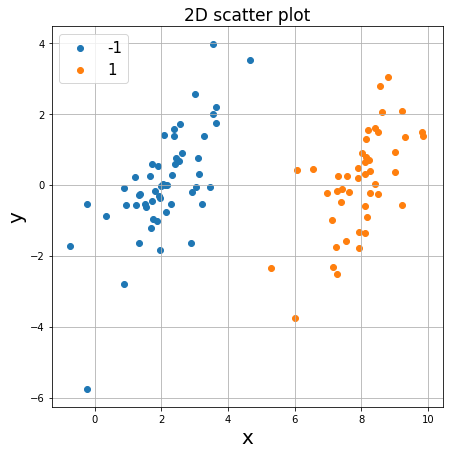

In [2]:
fig, ax = plt.subplots(figsize=(7, 7))


for label in data['label'].unique().tolist():
    if label == 1:
        ax.scatter(data[data['label'] == label]['x'], data[data['label'] == label]['y'], label=label)        
    else :
        ax.scatter(data[data['label'] == label]['x'], data[data['label'] == label]['y'], label=label)       

ax.set_title('2D scatter plot', fontsize=17)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
ax.legend(fontsize=15)
ax.grid(True)
plt.show()

### Scikit-Learn(libraray)의 SVM (검증용) 

C:\Users\LHJ\study\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


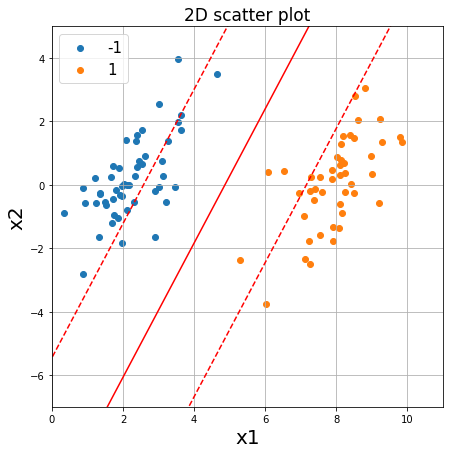

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# iteration = 1000 
clf = svm.LinearSVC(penalty='l2', C=1, max_iter=1000)
clf.fit(X, Y)

fig, ax = plt.subplots(figsize=(7, 7))

for label in data['label'].unique().tolist():
    if label == 1:
        ax.scatter(data[data['label'] == label]['x'], data[data['label'] == label]['y'], label=label)        
    else :
        ax.scatter(data[data['label'] == label]['x'], data[data['label'] == label]['y'], label=label)       

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-2,12)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

# plot the line, the points, and the nearest vectors to the plane
ax.plot(xx, yy, 'k-',  color='red')
ax.plot(xx, yy_down, 'k--', color='red')
ax.plot(xx, yy_up, 'k--',  color='red')

x_min = -4.8
x_max = 4.2
y_min = -6
y_max = 6

ax.set_xlim(0, 11)
ax.set_ylim(-7, 5)

ax.set_title('2D scatter plot', fontsize=17)
ax.set_xlabel('x1', fontsize=20)
ax.set_ylabel('x2', fontsize=20)
ax.legend(fontsize=15)
ax.grid(True)
plt.show()

In [28]:
clf.coef_

array([[ 0.43605543, -0.20628496]])

In [29]:
clf.intercept_[0]

-2.124299423118596

In [25]:
1 / np.sqrt(np.sum(clf.coef_ ** 2))

2.0730216520107416

In [24]:
np.sum(clf.coef_ ** 2)

0.23269782480811516

In [8]:
clf.intercept_[0]

-2.124299423118596

### CVXPY(library)를 사용한 SVM (ADMM)

In [2]:
# Form SVM with L1 regularization problem.

import cvxpy as cp

n = 2
m = 100

beta = cp.Variable((n,1))
v = cp.Variable()
loss = cp.sum(cp.pos(1 - cp.multiply(Y, X @ beta + v)))
reg = cp.norm(beta, 2)
lambd = cp.Parameter(nonneg=True)
prob = cp.Problem(cp.Minimize(loss/m + lambd*reg))

NameError: name 'Y' is not defined

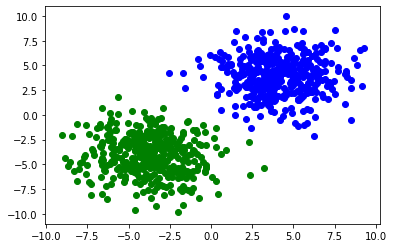

In [15]:
%matplotlib inline
import cvxpy
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import defs
np.random.seed(5)

#### Start with distributed SVMs
# Create a classification dataset
x1 = np.random.normal(4, 2, (2, 400))
x2 = np.random.normal(-4, 2, (2, 400))
X = np.hstack([x1, x2])
X = np.vstack([X, np.ones((1, 800))]) # add a bias term into the datapoints
Y = np.hstack([np.ones((1, 400)), -np.ones((1, 400))])
plt.scatter(X[0, :400], X[1, :400], color='blue')
plt.scatter(X[0, 400:], X[1, 400:], color='green')

In [22]:
duals = [np.zeros(3,) for _ in range(16)]
xs = [None] * 16
z = np.array([1, -1, 0])
zs = [z]

def plot_wxb(w, linestyle='solid', color='red'):
    x = np.arange(-10, 10)
    y = -(w[0] * x + w[2]) / w[1]
    plt.plot(x, y, color=color, linestyle=linestyle)
    
# def admm_inner_loop(rho, duals, z, i):
    
#     """
#     Run optimization over the i'th block.
#     """
#     block = blocks[i]
#     w = cvxpy.Variable(3)
#     obj_term = 0
#     for data_ind in block:
#         obj_term += cvxpy.pos(1 - Y[0, data_ind] * w.T * X[:, data_ind])
#     obj_term += w.T * duals[i] - z.dot(duals[i])
#     obj_term += rho / 2 * cvxpy.quad_form(w - z, np.eye(3))
#     cvxpy.Problem(cvxpy.Minimize(obj_term), []).solve()
#     return np.array(w.value).squeeze()


if __name__ == '__main__':
    def admm_iter(rho, duals, z):
        """
        Runs one iteration of ADMM. Each block optimization happens 
        in a different process, in parallel. The results are aggregated
        and used to update the dual/consensus variables
        """
        new_ws = []
        args = [(rho, duals, z, i) for i in range(16)]
        pool = multiprocessing.Pool(16)
        print(args[0])
        new_ws = pool.map(defs.admm_inner_loop, args)
        pool.close()
        new_z = 0
        for i in range(16):
            new_z += new_ws[i] + duals[i] / rho
        new_z /= 16

        new_duals = [duals[i] + rho * (new_ws[i] - new_z) for i in range(16)]
        return [new_ws[i] + duals[i] / rho for i in range(16)], new_duals, new_z
        
    for iteration in range(7):
        print('Running ADMM iter', iteration+1, '/', 7)
        new_ws, duals, z = admm_iter(0.5, duals, z)
        zs.append(z)

    plt.scatter(X[0, :400], X[1, :400], color='blue')
    plt.scatter(X[0, 400:], X[1, 400:], color='green')
    for i, z in enumerate(zs):
        linestyle = 'dashed' if i < len(zs) - 1 else 'solid'
        plot_wxb(z, linestyle=linestyle)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)

Running ADMM iter 1 / 7
[0.5, [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])], array([ 1, -1,  0]), 0]


TypeError: map() takes from 3 to 4 positional arguments but 18 were given

In [78]:
args = [(0.5, duals, z, i) for i in range(16)]
len(args)
# def admm_inner_loop((rho, duals, z, i)):
#     print(rho)
#     print(duals)
#     print(z)
#     print(i)

16

In [73]:
def admm_inner_loop(*args):
    print(len(*args))
#     #rho, duals, z, i = *args
#     [[i,j,k, l] for i,j,k, l in *args]
#     print(rho)
#     print(duals)
#     print(z)
#     print(i)

In [86]:
j = 0
for i in args:
    print(i)
    print('---------------------------------')
    j += 1

print(j)

(0.5, [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])], array([ 1, -1,  0]), 0)
---------------------------------
(0.5, [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])], array([ 1, -1,  0]), 1)
---------------------------------
(0.5, [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.]), 

In [88]:
import defs

In [91]:
# Setup.
pipes = []
procs = []
for i in range(NUM_PROCS):
    local, remote = Pipe()
    pipes += [local]
    procs += [Process(target=run_process, args=(f[i], remote))]
    procs[-1].start()

# ADMM loop.
for i in range(MAX_ITER):
    # Gather.
    xbar = sum([pipe.recv() for pipe in pipes])/NUM_PROCS
    print(get_error(xbar))
    # Scatter.
    [pipe.send(xbar) for pipe in pipes]

[p.terminate() for p in procs]

NameError: name 'NUM_PROCS' is not defined